In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.pylab as pylab

import numpy as np
import os
import itertools
from random import sample
from math import log

from typing import List, Dict

from operator import itemgetter


params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 18,
         'axes.titlesize': 20,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}

pylab.rcParams.update(params)


def parse_metrics(path):
    # Read the JSON file
    with open(path) as f:
        data = json.load(f)
    
    epochs, losses, eval_losses, accuracies, lrs = [], [], [], [], []
    for entry in data['log_history']:
        if 'loss' in entry:
            epochs.append(entry['epoch'])
            losses.append(entry['loss'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])
        if 'eval_accuracy' in entry:
            accuracies.append(entry['eval_accuracy'])
        if 'loss' in entry:
            lrs.append(entry['learning_rate'])
            
    epochs, losses, eval_losses, accuracies, lrs = np.array(epochs), np.array(losses), np.array(eval_losses), np.array(accuracies), np.array(lrs)
    if len(eval_losses) > 0:
        min_eval_idx = np.argmin(eval_losses)
        epoch_eval_min, eval_min = epochs[min_eval_idx], eval_losses[min_eval_idx]
    else: 
        min_eval_idx, epoch_eval_min, eval_min = None, None, None
    
    if len(accuracies) > 0:
        max_acc_idx = np.argmax(accuracies)
        epoch_acc_max, acc_max = epochs[max_acc_idx], accuracies[max_acc_idx]
    else:
        max_acc_idx, epoch_acc_max, acc_max = None, None, None
        
    min_train_idx = np.argmin(losses)
    epoch_train_min, train_min = epochs[min_train_idx], losses[min_train_idx]
    
    metrics = {
        'min_eval_idx': min_eval_idx,
        'epoch_eval_min': epoch_eval_min,
        'eval_min': eval_min,
        'max_acc_idx': max_acc_idx,
        'epoch_acc_max': epoch_acc_max,
        'acc_max': acc_max,
        
        'min_train_idx': min_train_idx,
        'epoch_train_min': epoch_train_min,
        'train_min': train_min,
        
        'epochs': epochs,
        'losses': losses,
        'eval_losses': eval_losses,
        'accuracies': accuracies,
        'lrs': lrs,
    }
    return metrics


def plot_metrics_same_canvas(list_metrics, labels, xlim=None, ylim=None, plot_train=False, plot_eval=True, title='', figsize=None, **kwargs):  
    figsize = figsize if figsize is not None else (10, 5)
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    
    for idx, metrics in enumerate(list_metrics):
        if plot_train:
            ax1.plot(metrics['epochs'], metrics['losses'], marker='o', markersize=4, linestyle='-', linewidth=0.5, label=f'train {labels[idx]}')
        if plot_eval:
            ax1.plot(metrics['epochs'], metrics['eval_losses'], marker='+', markersize=4, linestyle='-', linewidth=0.5, label=f'{labels[idx]}')
        
    # set labels
    ax1.set_xlabel('Epoch'), ax1.set_ylabel('Loss'), ax1.set_title(f'{title}')
    if xlim is not None:
        ax1.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax1.set_ylim(ylim[0], ylim[1])
    ax1.grid(), ax1.legend()
    
    plt.show()


def plot_metrics(metrics, xlim=None, ylim=None, plot_train=True, plot_eval=True, plot_acc=True, 
                 title='', custom_text=None, **kwargs):  
    if plot_acc:
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20, 5))
    else:
        figsize = figsize if figsize is not None else (8, 4)
        fig, ax1 = plt.subplots(1, 1, figsize=figsize)
        
    # Plot loss vs epoch
    if plot_train:
        ax1.plot(metrics['epochs'], metrics['losses'], marker='o', markersize=4, linestyle='-', linewidth=0.5, label='train')
    if plot_eval:
        ax1.plot(metrics['epochs'], metrics['eval_losses'], marker='+', markersize=4, linestyle='-', linewidth=0.5, label='eval')
    if custom_text is not False:
        x_min, x_max, y_min, y_max = ax1.axis()

        # Set the text coordinates to the top-right corner
        text_x = x_max - 0.45 * (x_max - x_min)
        text_y = y_max - 0.2 * (y_max - y_min)
        ax1.text(text_x, text_y, custom_text, fontsize=14, color='blue')
        
        
    # set labels
    ax1.set_xlabel('Epoch'), ax1.set_ylabel('Loss'), ax1.set_title(f'Loss vs Epoch {title}')
    if xlim is not None:
        ax1.set_xlim(xlim[0], xlim[1])
    if ylim is not None:
        ax1.set_ylim(ylim[0], ylim[1])
    ax1.grid(), ax1.legend()
    
    if plot_acc:
        ax2.plot(metrics['epochs'], metrics['accuracies'], marker='o', markersize=3, linestyle='-', linewidth=0.5)
        ax2.set_xlabel('Epoch'), ax2.set_ylabel('accuracies'), ax2.set_title(f'Accuracy vs Epoch')
        ax2.grid(), ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
def pipeline(output_folder, settings={}, plot_graph=True):
    path = os.path.join("/scratch/gpfs/mb5157/repos/graphmert/graphmert", output_folder, "trainer_state.json")
    metrics = parse_metrics(path)
    
    if settings.get('get_train'):
        epoch_train_min, train_min = round(metrics['epoch_train_min'], 2), round(metrics['train_min'], 4)

    epoch_eval_min, eval_min, epoch_acc_max, acc_max = round(metrics['epoch_eval_min'], 2), round(metrics['eval_min'], 4), round(metrics['epoch_acc_max'],2), round(metrics['acc_max'], 3)
    custom_text = f"""epoch: {epoch_eval_min} min eval: {eval_min}\nepoch: {epoch_acc_max} max acc: {acc_max}"""

    if plot_graph:
        if 'custom_text' not in settings:
            plot_metrics(metrics, custom_text=custom_text, **settings)
        else:
            plot_metrics(metrics, **settings)
        
    acc_for_min_eval = metrics['accuracies'][metrics['min_eval_idx']]
    eval_for_max_acc = metrics['eval_losses'][metrics['max_acc_idx']]
    if settings.get('get_train') == True:
        print(f"""epoch: {epoch_train_min} min train: {train_min}""")
    if settings.get('get_acc') == True:
        print(f"""epoch: {epoch_acc_max} max acc: {acc_max}""")
    if settings.get('get_eval') == True:
        print(f"""epoch: {epoch_eval_min} min eval: {eval_min}""")
    return metrics


def process_all_folders(folders: List, model_flavor: str, settings: Dict = {}, plot_graph=True):
    best_values = []
    if settings == {}:
        settings['get_eval'], settings['get_acc'] = True, True
    for folder in folders:
        lr = folder.split('_')[-1]
        settings['title'] = f"{model_flavor}: lr {lr}"
        metrics = pipeline(folder, settings, plot_graph)
        if settings.get('get_eval') == True:
            min_loss, acc_max = round(metrics['eval_min'], 4), round(metrics['acc_max'], 4)
        try:
            best_values.append((float(lr), min_loss, acc_max))
        except ValueError as err:
            best_values.append((lr, min_loss, acc_max))
            
    eval_best_values = sorted(best_values, key=itemgetter(1))
    acc_best_values = sorted(best_values, reverse=True, key=itemgetter(2))
    
    eval_loss_by_epoch = [(metrics['epochs'][i], round(metrics['eval_losses'][i], 3)) for i in range(len(metrics['epochs']))]
    return eval_loss_by_epoch, eval_best_values, acc_best_values


# Qwen

### score 0.55

/tmp/ipykernel_3431982/1286166512.py:134: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.grid(), ax2.legend()


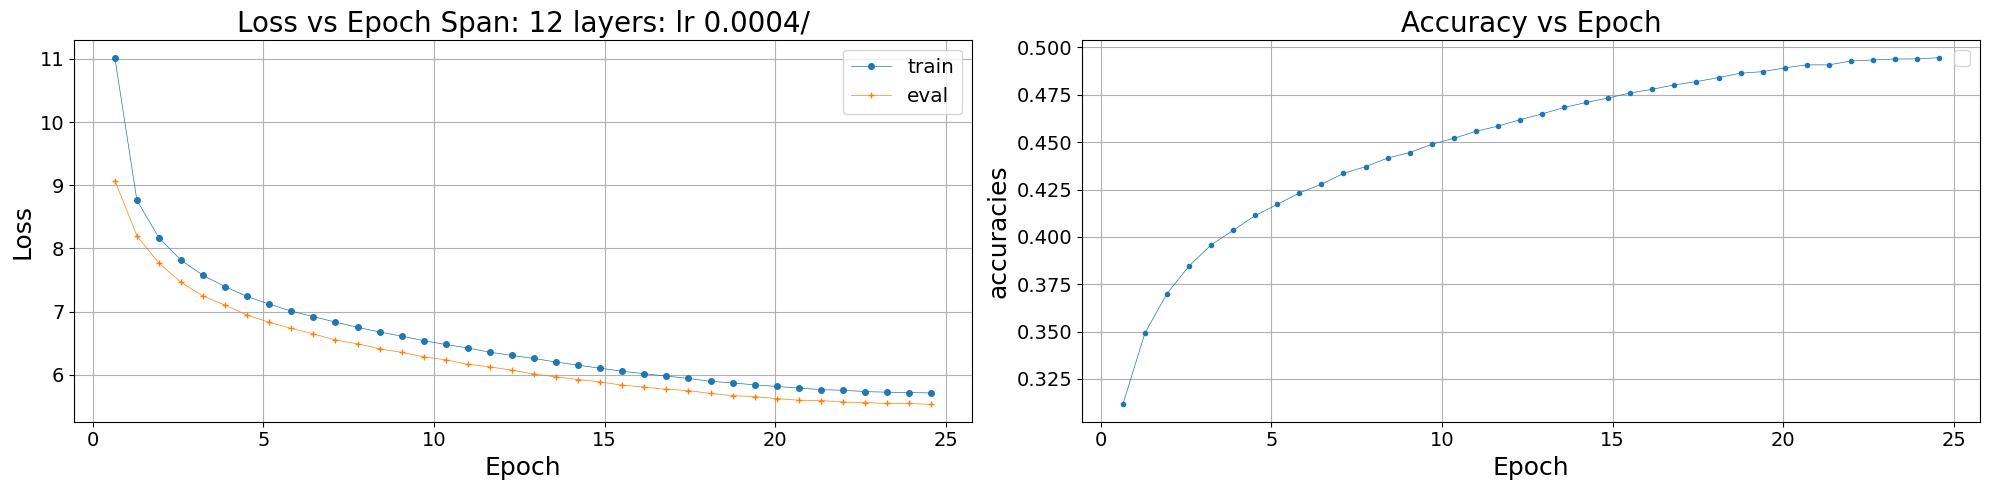

epoch: 24.57 min train: 5.7147
epoch: 24.57 min eval: 5.5332


In [11]:
model_flavor = 'Span: 12 layers'

output_folders = [
    'outputs/350abstracts/qwen32/score0.55/span/rel29/bs256_lr_0.0004/',
]

settings = {
    'plot_train' : True,
    # 'ylim': (2.4, 3),
    'custom_text': False,
    'get_eval': True,
    'get_train': True,
}
      
eval_loss_by_epoch, eval_best_values, acc_best_values = process_all_folders(output_folders, model_flavor, settings)